# Import the modules

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import shutil
import os
from matplotlib import pyplot as plt
plt.style.use('seaborn')
from matplotlib import image as img

LOCAL = not 'CLOUDSDK_CONFIG' in os.environ

if not LOCAL:
  
  from google.colab import files, drive, output

2.7.0


## Download the Pokemon dataset
We will first download the archive of the dataset and then unzip it. The image dataset are directly re-used from PyImageSearch https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns. The blog post has some great discussion on the Convolutional Neural Network (CNN). Do take a look when you have time.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll" -O dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q dataset.zip
!ls

--2021-11-10 05:49:49--  https://docs.google.com/uc?export=download&confirm=vn8N&id=1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll
Resolving docs.google.com (docs.google.com)... 209.85.200.113, 209.85.200.139, 209.85.200.101, ...
Connecting to docs.google.com (docs.google.com)|209.85.200.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-2s-docs.googleusercontent.com/docs/securesc/39c6shcs345ej5b7s6j4k4c8rgg92h5f/dfjmsdouomf1aj15jrqn7hgp2recjr3d/1636523325000/07232970392308685987/10156232151158977081Z/1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll?e=download [following]
--2021-11-10 05:49:49--  https://doc-00-2s-docs.googleusercontent.com/docs/securesc/39c6shcs345ej5b7s6j4k4c8rgg92h5f/dfjmsdouomf1aj15jrqn7hgp2recjr3d/1636523325000/07232970392308685987/10156232151158977081Z/1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll?e=download
Resolving doc-00-2s-docs.googleusercontent.com (doc-00-2s-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connectin

In [ ]:
ls dataset/

bulbasaur/  charmander/  mewtwo/  pikachu/  README  squirtle/


## Building Model
Here we will build our Convolutional Neural Network (CNN) using Keras APIs and TensorFlow backend.

###Plot some images

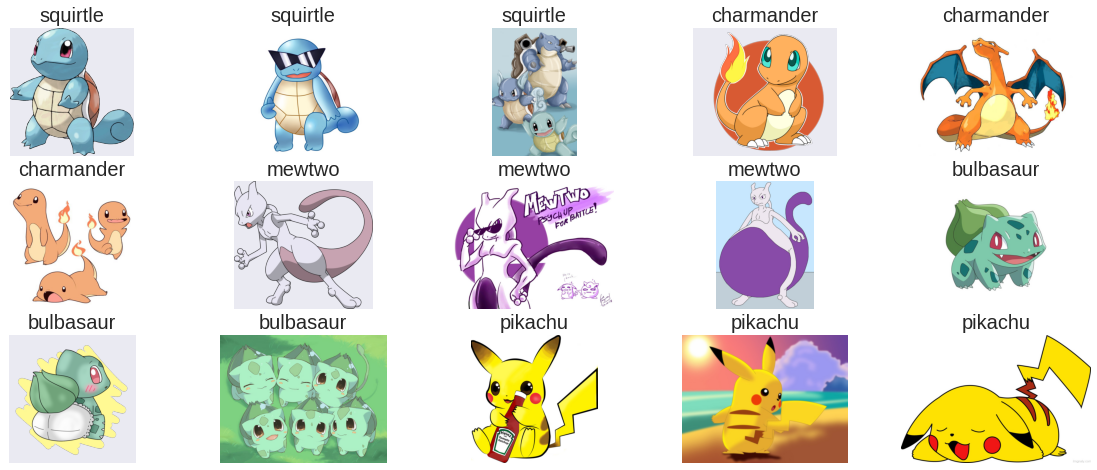

In [ ]:
sample = list()
size = 3
i = 0
figure = plt.figure(figsize=(20,8))

for item in os.listdir('dataset/'):
  if item!='README':
    imagedir = os.path.join('dataset/',item)
    imageitem = os.listdir(imagedir)
    subset = np.random.choice(imageitem, 3, replace=False)
    
    for image_sample in subset:
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.set_title(imagedir.split('/')[1], fontsize=20)
      ax.imshow(img.imread( os.path.join(imagedir,image_sample),0 ))
      i+=1

### Generate training/evalaution dataset

In [ ]:
IMG_SIZE_HEIGHT = 96
IMG_SIZE_WIDTH = 96

data_generator = image.ImageDataGenerator(rescale=1./255, validation_split=0.3)


train_generator = data_generator.flow_from_directory("./dataset",
                                                     shuffle=True,
                                                     target_size=(
                                                     IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     subset="training",
                                                     seed=1
                                                     )

validation_generator = data_generator.flow_from_directory("./dataset",
                                                          shuffle=True,
                                                          target_size=(
                                                          IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH),
                                                          color_mode='rgb',
                                                          class_mode='categorical',
                                                          subset="validation",
                                                          seed=1
                                                          )
                                                  


Found 820 images belonging to 5 classes.
Found 347 images belonging to 5 classes.


### Defines  the CNN model

## Task: In this section, we are going to define our CNN model

***Implement a CNN which consists of:***


1.   **Conv2D layer 1**
> filters=16, 
> kernel_size=(5,5), 
> strides=(1,1), 
> activation='relu', 
> input_shape=(IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT, 3)
2.   **MaxPooling2D layer 1**
> pool_size=(5,5), 
> strides=(1,1)
3.   **Conv2D layer 2**
> filters=16, 
> kernel_size=(3,3), 
> strides=1, 
> activation='relu'
4.   **MaxPooling2D layer 2**
> pool_size=(3,3),
> strides=(1,1)
5.   **Flatten layer**
6.   **Dense layer**
> units=100, activation='relu'
7.   **Output (Dense) layer**
> units=NUM_CLASSES, activation='softmax'




We used the softmax function to map the network's output scores into class probabilities:

$$ softmax(s_i) = \frac{\exp(s_i)}{\sum_{j=1}^K \exp(s_j)} $$

**Links to the documentation for your reference:**

Input layer:
https://www.tensorflow.org/api_docs/python/tf/keras/Input

Convolutional layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

Pooling layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D


Flatten layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten


Dense layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense







In [ ]:
clear_session()

NUM_CLASSES = 5

# building the CNN model

model = Sequential()

# Type your code here 
#===============================================================================














#===============================================================================


model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=1e-3), metrics=["accuracy"])
    
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 84, 84, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 112896)            0         
                                                                 
 dense (Dense)               (None, 100)               1

### Fitting the data into the model

In [ ]:


es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1,restore_best_weights=True)


NUM_EPOCHS = 300


# Fitting the data into the model
result = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    callbacks=[es],
)



Epoch 1/300
23/26 [=========================>....] - ETA: 2s - loss: 5.9211 - accuracy: 0.2914

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 30s 1s/step - loss: 5.3913 - accuracy: 0.3085 - val_loss: 1.2353 - val_accuracy: 0.6542
Epoch 2/300
26/26 [==============================] - 28s 1s/step - loss: 1.0024 - accuracy: 0.6195 - val_loss: 0.6437 - val_accuracy: 0.7867
Epoch 3/300
26/26 [==============================] - 28s 1s/step - loss: 0.7471 - accuracy: 0.7207 - val_loss: 0.6850 - val_accuracy: 0.7810
Epoch 4/300
26/26 [==============================] - 29s 1s/step - loss: 0.6491 - accuracy: 0.7610 - val_loss: 0.4095 - val_accuracy: 0.8761
Epoch 5/300
26/26 [==============================] - 29s 1s/step - loss: 0.4272 - accuracy: 0.8598 - val_loss: 0.3625 - val_accuracy: 0.9222
Epoch 6/300
26/26 [==============================] - 29s 1s/step - loss: 0.3106 - accuracy: 0.8927 - val_loss: 0.4304 - val_accuracy: 0.8444
Epoch 7/300
26/26 [==============================] - 29s 1s/step - loss: 0.2640 - accuracy: 0.9110 - val_loss: 0.3832 - val_accuracy: 0.8674
Epoch 00007: early stoppi

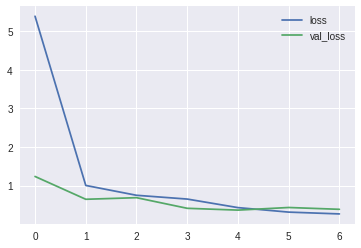

In [ ]:
pd.DataFrame(result.history)[['loss','val_loss']].plot()

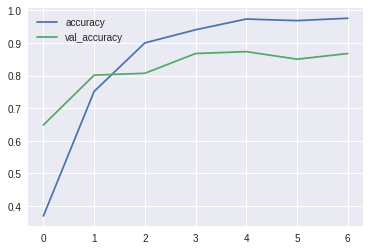

In [ ]:
pd.DataFrame(result.history)[['accuracy','val_accuracy']].plot()

In [ ]:
filename = 'model.hdf5'


model.save(filename)
#model = load_model(filename)

In [ ]:
res = model.evaluate(validation_generator)
names = model.metrics_names
for i in range(len(res)):
  print(f'{names[i]}: {res[i]}')

 3/11 [=======>......................] - ETA: 6s - loss: 0.2140 - accuracy: 0.9167

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/11 [==============================] - 9s 778ms/step - loss: 0.2188 - accuracy: 0.9193
loss: 0.21878410875797272
accuracy: 0.9193083643913269


## Making Prediction

In [ ]:
if not LOCAL:
  # Create folder for file upload
  if not os.path.exists('./data/unknown'):
      os.makedirs('./data/unknown')
  else:
      shutil.rmtree('./data/unknown')
      os.makedirs('./data/unknown')

  uploaded = files.upload()

  for file_name in uploaded:

    shutil.move(file_name, os.path.join('./data/unknown', file_name))

    directory_path =  "./data"
else:
    directory_path =  "./test_data"



In [ ]:
predict_datagen = image.ImageDataGenerator(rescale=1./255)
predict_generator =  predict_datagen.flow_from_directory(
        directory_path,
        target_size=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH),
        color_mode="rgb",
        class_mode='categorical',
        batch_size=1)

filenames = predict_generator.filenames
predictions = model.predict(predict_generator)



prediction = np.argmax(predictions, axis=1)

label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
prediction = [label_map[k] for k in prediction]

filenames_predictions_map = list(zip(filenames, prediction))
print (filenames_predictions_map)

In [ ]:
figure = plt.figure(figsize=(25,10))
for i, (filename, pred_class) in enumerate(filenames_predictions_map):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])

   
    ax.set_title("{} ({:.2f}%) ({})".format(
                                  prediction[i], 
                                  np.max(predictions[i])*100,
                                  filename),
                 
                )
    ax.imshow(img.imread(os.path.join('./data/',filename)))
                                  
